In [1]:
from __future__ import print_function
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys


from datetime import datetime
%load_ext tensorboard


### Extract train features

In [2]:
X_train_bonafide_list = []
X_train_spoof_list = []
max_lpc_order = 50
lpc_lengths = np.arange(1, max_lpc_order + 1)


for l in lpc_lengths:
    train_features = pd.read_pickle('/nas/home/cborrelli/bot_speech/features/train_LPC_' + str(l) +'.pkl')
    #train_features.drop('coeff', axis=1, inplace=True)
    train_features.dropna(inplace=True)
    
    train_bonafide_features = train_features[train_features['label']=='bonafide']
    train_spoof_features = train_features[train_features['label']=='spoof']
    
    if l==1:
        train_spoof_features = train_features[train_features['label']=='spoof'].sample(
            n=train_bonafide_features.shape[0])
        selected_files = train_spoof_features['audio_filename']
    else:
        train_spoof_features = train_spoof_features[train_spoof_features['audio_filename'].isin(selected_files)]
    X_train_bonafide_list.append(np.array(train_bonafide_features['lpc_res_mean']).reshape((-1, 1)))
    X_train_bonafide_list.append(np.array(train_bonafide_features['lpc_res_max']).reshape((-1, 1)))
    X_train_bonafide_list.append(np.array(train_bonafide_features['lpc_res_min']).reshape((-1, 1)))
    X_train_bonafide_list.append(np.array(train_bonafide_features['lpc_res_var']).reshape((-1, 1)))
    X_train_bonafide_list.append(np.array(train_bonafide_features['lpc_gain_max']).reshape((-1, 1)))
    X_train_bonafide_list.append(np.array(train_bonafide_features['lpc_gain_min']).reshape((-1, 1)))
    X_train_bonafide_list.append(np.array(train_bonafide_features['lpc_gain_mean']).reshape((-1, 1)))
    X_train_bonafide_list.append(np.array(train_bonafide_features['lpc_gain_var']).reshape((-1, 1)))
    X_train_bonafide_list.append(np.array(train_bonafide_features['ltp_res_mean']).reshape((-1, 1)))
    X_train_bonafide_list.append(np.array(train_bonafide_features['ltp_res_max']).reshape((-1, 1)))
    X_train_bonafide_list.append(np.array(train_bonafide_features['ltp_res_min']).reshape((-1, 1)))
    X_train_bonafide_list.append(np.array(train_bonafide_features['ltp_res_var']).reshape((-1, 1)))
    X_train_bonafide_list.append(np.array(train_bonafide_features['ltp_gain_max']).reshape((-1, 1)))
    X_train_bonafide_list.append(np.array(train_bonafide_features['ltp_gain_min']).reshape((-1, 1)))
    X_train_bonafide_list.append(np.array(train_bonafide_features['ltp_gain_mean']).reshape((-1, 1)))
    X_train_bonafide_list.append(np.array(train_bonafide_features['ltp_gain_var']).reshape((-1, 1)))


    X_train_spoof_list.append(np.array(train_spoof_features['lpc_res_mean']).reshape((-1, 1)))
    X_train_spoof_list.append(np.array(train_spoof_features['lpc_res_max']).reshape((-1, 1)))
    X_train_spoof_list.append(np.array(train_spoof_features['lpc_res_min']).reshape((-1, 1)))
    X_train_spoof_list.append(np.array(train_spoof_features['lpc_res_var']).reshape((-1, 1)))
    X_train_spoof_list.append(np.array(train_spoof_features['lpc_gain_max']).reshape((-1, 1)))
    X_train_spoof_list.append(np.array(train_spoof_features['lpc_gain_min']).reshape((-1, 1)))
    X_train_spoof_list.append(np.array(train_spoof_features['lpc_gain_mean']).reshape((-1, 1)))
    X_train_spoof_list.append(np.array(train_spoof_features['lpc_gain_var']).reshape((-1, 1)))
    X_train_spoof_list.append(np.array(train_spoof_features['ltp_res_mean']).reshape((-1, 1)))
    X_train_spoof_list.append(np.array(train_spoof_features['ltp_res_max']).reshape((-1, 1)))
    X_train_spoof_list.append(np.array(train_spoof_features['ltp_res_min']).reshape((-1, 1)))
    X_train_spoof_list.append(np.array(train_spoof_features['ltp_res_var']).reshape((-1, 1)))
    X_train_spoof_list.append(np.array(train_spoof_features['ltp_gain_max']).reshape((-1, 1)))
    X_train_spoof_list.append(np.array(train_spoof_features['ltp_gain_min']).reshape((-1, 1)))
    X_train_spoof_list.append(np.array(train_spoof_features['ltp_gain_mean']).reshape((-1, 1)))
    X_train_spoof_list.append(np.array(train_spoof_features['ltp_gain_var']).reshape((-1, 1)))





In [3]:
X_train_bonafide = np.concatenate(X_train_bonafide_list, axis=1)
X_train_spoof = np.concatenate(X_train_spoof_list, axis=1)
X_train = np.concatenate((X_train_bonafide, X_train_spoof), axis=0)

y_train_bonafide = np.zeros((X_train_bonafide.shape[0],))
y_train_spoof = np.ones((X_train_spoof.shape[0],))

y_train = np.concatenate((y_train_bonafide, y_train_spoof), axis=0)

### Extract dev features

In [4]:
X_dev_bonafide_list = []
X_dev_spoof_list = []

for l in lpc_lengths:
    dev_features = pd.read_pickle('/nas/home/cborrelli/bot_speech/features/dev_LPC_' + str(l) +'.pkl')
    #dev_features.drop('coeff', axis=1, inplace=True)
    dev_features.dropna(inplace=True)  
    
    dev_bonafide_features = dev_features[dev_features['label']=='bonafide']
    dev_spoof_features = dev_features[dev_features['label']=='spoof']
    
    if l==1:
        dev_spoof_features = dev_features[dev_features['label']=='spoof'].sample(n=dev_bonafide_features.shape[0])
        selected_files = dev_spoof_features['audio_filename']
    else:
        dev_spoof_features = dev_spoof_features[dev_spoof_features['audio_filename'].isin(selected_files)]
    
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['lpc_res_mean']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['lpc_res_max']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['lpc_res_min']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['lpc_res_var']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['lpc_gain_max']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['lpc_gain_min']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['lpc_gain_mean']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['lpc_gain_var']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['ltp_res_mean']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['ltp_res_max']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['ltp_res_min']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['ltp_res_var']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['ltp_gain_max']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['ltp_gain_min']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['ltp_gain_mean']).reshape((-1, 1)))
    X_dev_bonafide_list.append(np.array(dev_bonafide_features['ltp_gain_var']).reshape((-1, 1)))
    
    X_dev_spoof_list.append(np.array(dev_spoof_features['lpc_res_mean']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['lpc_res_max']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['lpc_res_min']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['lpc_res_var']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['lpc_gain_max']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['lpc_gain_min']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['lpc_gain_mean']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['lpc_gain_var']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['ltp_res_mean']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['ltp_res_max']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['ltp_res_min']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['ltp_res_var']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['ltp_gain_max']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['ltp_gain_min']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['ltp_gain_mean']).reshape((-1, 1)))
    X_dev_spoof_list.append(np.array(dev_spoof_features['ltp_gain_var']).reshape((-1, 1)))

In [5]:
X_dev_bonafide = np.concatenate(X_dev_bonafide_list, axis=1)
X_dev_spoof = np.concatenate(X_dev_spoof_list, axis=1)
X_dev = np.concatenate((X_dev_bonafide, X_dev_spoof), axis=0)

y_dev_bonafide = np.zeros((X_dev_bonafide.shape[0],))
y_dev_spoof = np.ones((X_dev_spoof.shape[0],))

y_dev = np.concatenate((y_dev_bonafide, y_dev_spoof), axis=0)

### Extract eval features

In [6]:
X_eval_bonafide_list = []
X_eval_spoof_list = []

for l in lpc_lengths:
    eval_features = pd.read_pickle('/nas/home/cborrelli/bot_speech/features/eval_LPC_' + str(l) +'.pkl')
    #eval_features = eval_features[~eval_features['audio_filename'].isin(excluded_files)]
    #eval_features.drop('coeff', axis=1, inplace=True)
    eval_features.dropna(inplace=True)

    eval_bonafide_features = eval_features[eval_features['label']=='bonafide']
    eval_spoof_features= eval_features[eval_features['label']=='spoof']
    
    if l==1:
        eval_spoof_features = eval_features[eval_features['label']=='spoof'].sample(
            n=eval_bonafide_features.shape[0])
        selected_files = eval_spoof_features['audio_filename']
    else:
        eval_spoof_features = eval_spoof_features[eval_spoof_features['audio_filename'].isin(selected_files)]
    
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['lpc_res_mean']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['lpc_res_max']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['lpc_res_min']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['lpc_res_var']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['lpc_gain_max']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['lpc_gain_min']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['lpc_gain_mean']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['lpc_gain_var']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['ltp_res_mean']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['ltp_res_max']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['ltp_res_min']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['ltp_res_var']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['ltp_gain_max']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['ltp_gain_min']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['ltp_gain_mean']).reshape((-1, 1)))
    X_eval_bonafide_list.append(np.array(eval_bonafide_features['ltp_gain_var']).reshape((-1, 1)))

    X_eval_spoof_list.append(np.array(eval_spoof_features['lpc_res_mean']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['lpc_res_max']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['lpc_res_min']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['lpc_res_var']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['lpc_gain_max']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['lpc_gain_min']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['lpc_gain_mean']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['lpc_gain_var']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['ltp_res_mean']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['ltp_res_max']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['ltp_res_min']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['ltp_res_var']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['ltp_gain_max']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['ltp_gain_min']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['ltp_gain_mean']).reshape((-1, 1)))
    X_eval_spoof_list.append(np.array(eval_spoof_features['ltp_gain_var']).reshape((-1, 1)))

In [7]:
X_eval_bonafide = np.concatenate(X_eval_bonafide_list, axis=1)
X_eval_spoof = np.concatenate(X_eval_spoof_list, axis=1)
X_eval = np.concatenate((X_eval_bonafide, X_eval_spoof), axis=0)

y_eval_bonafide = np.zeros((X_eval_bonafide.shape[0],))
y_eval_spoof = np.ones((X_eval_spoof.shape[0],))

y_eval = np.concatenate((y_eval_bonafide, y_eval_spoof), axis=0)

In [8]:
X_train.shape[1]

800

## Reshape data for CNN

In [9]:
n_features = 16
lpc_lenght = 50
reshaped_X_train = np.zeros([X_train.shape[0], n_features, lpc_lenght ])
for n in np.arange(X_train.shape[0]):
    for i in np.arange(n_features):
        reshaped_X_train[n, i, :] = X_train[n, i::n_features]

print(reshaped_X_train.shape)

(5036, 16, 50)


In [10]:
n_features = 16
lpc_lenght = 50
reshaped_X_eval = np.zeros([X_eval.shape[0], n_features, lpc_lenght ])
for n in np.arange(X_eval.shape[0]):
    for i in np.arange(n_features):
        reshaped_X_eval[n, i, :] = X_eval[n, i::n_features]

print(reshaped_X_eval.shape)

(14080, 16, 50)


In [11]:
n_features = 16
lpc_lenght = 50
reshaped_X_dev = np.zeros([X_dev.shape[0], n_features, lpc_lenght ])
for n in np.arange(X_dev.shape[0]):
    for i in np.arange(n_features):
        reshaped_X_dev[n, i, :] = X_dev[n, i::n_features]

print(reshaped_X_dev.shape)

(4834, 16, 50)


## Normalize features

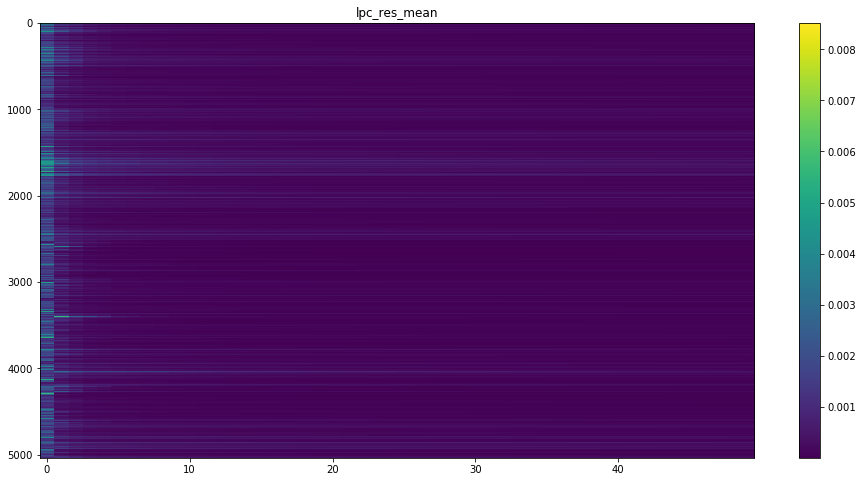

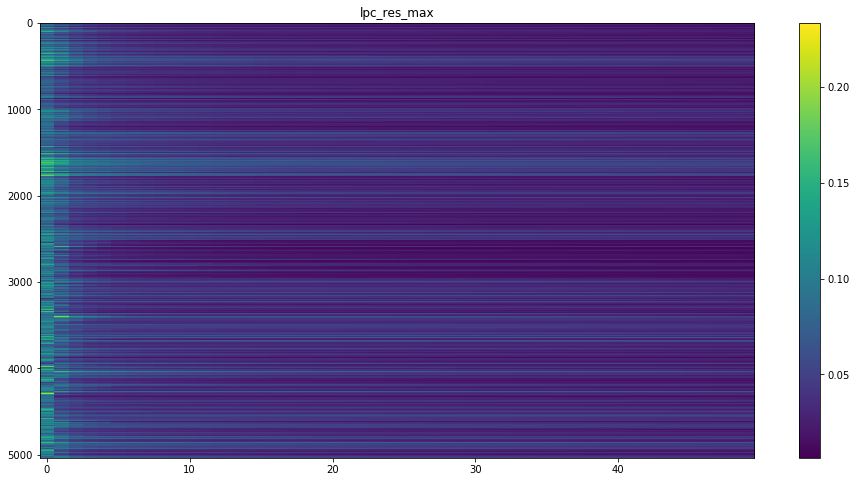

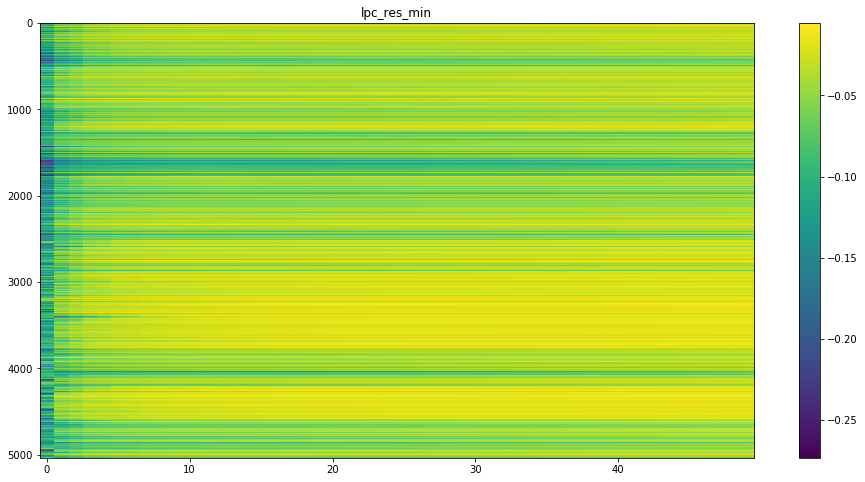

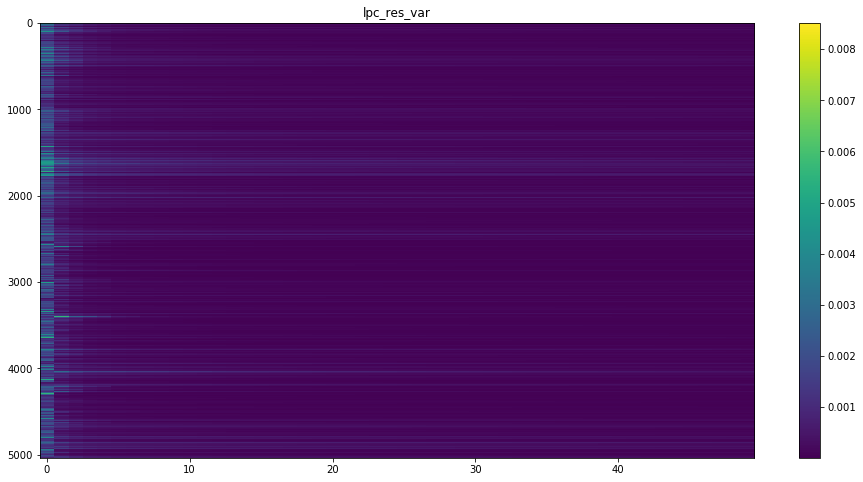

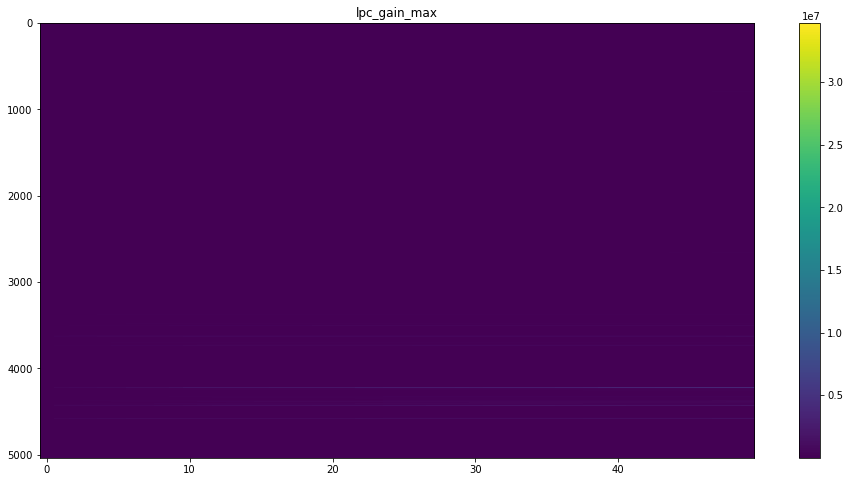

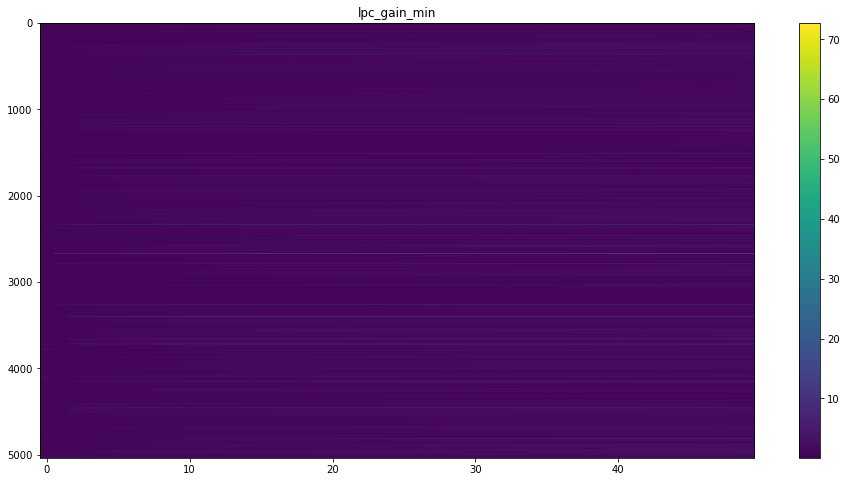

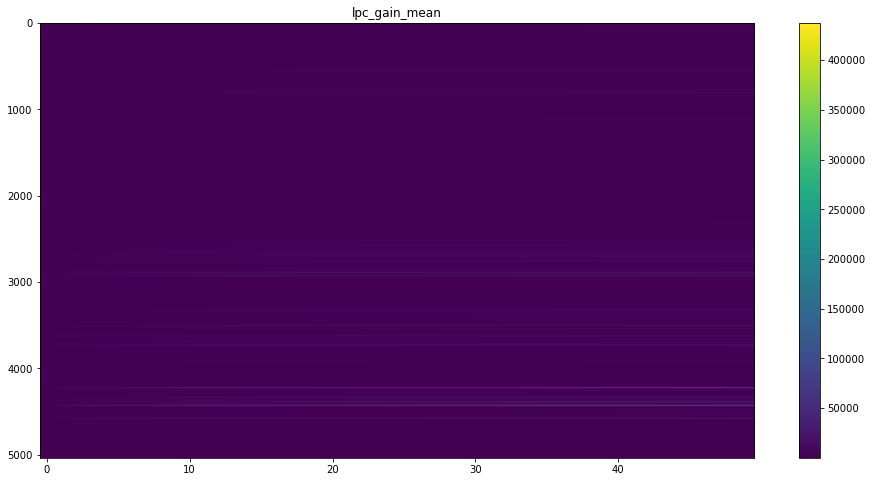

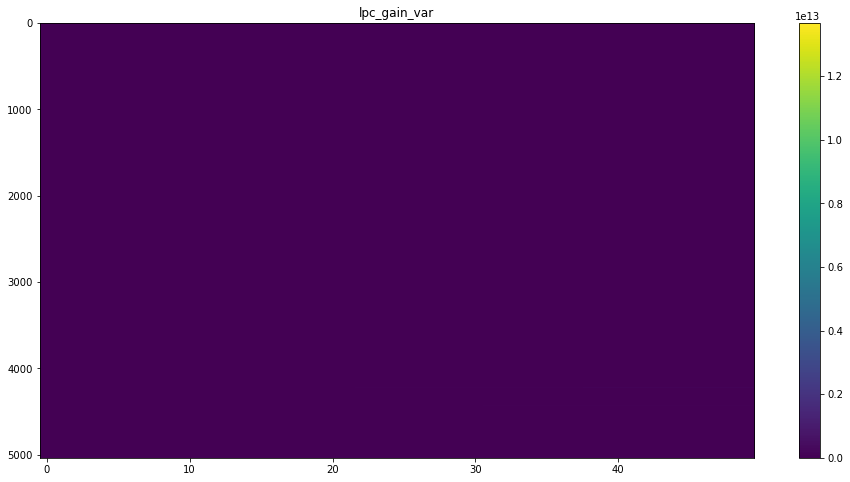

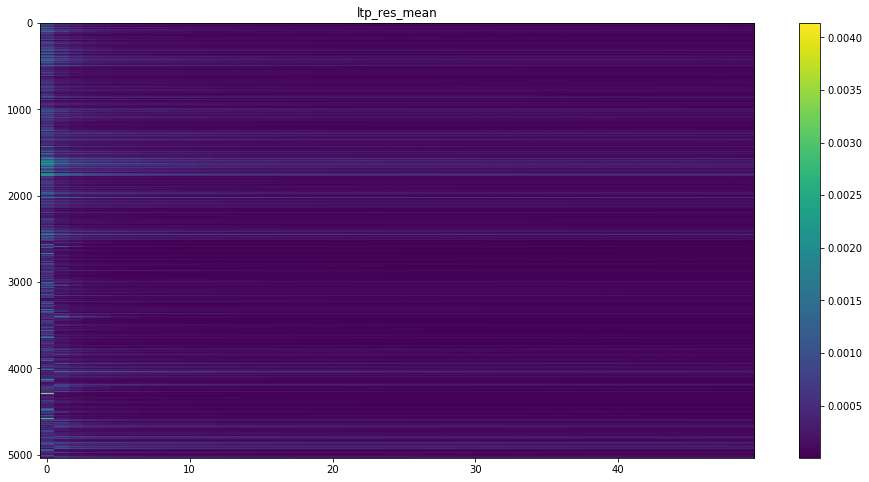

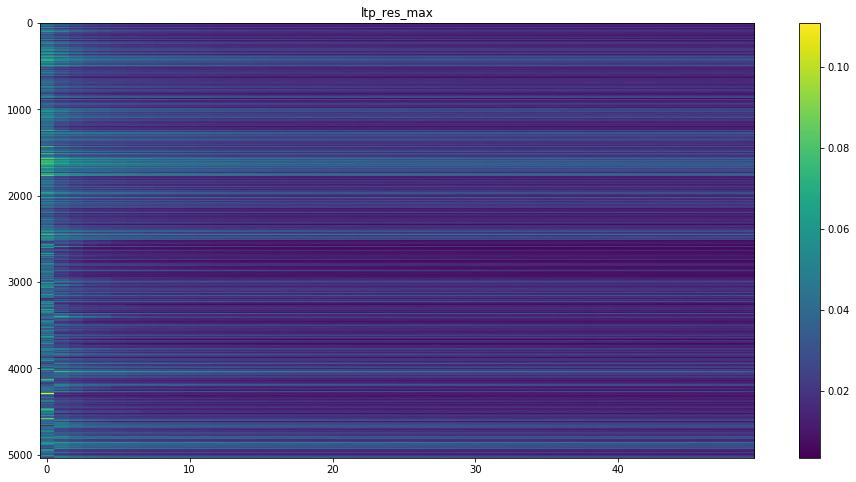

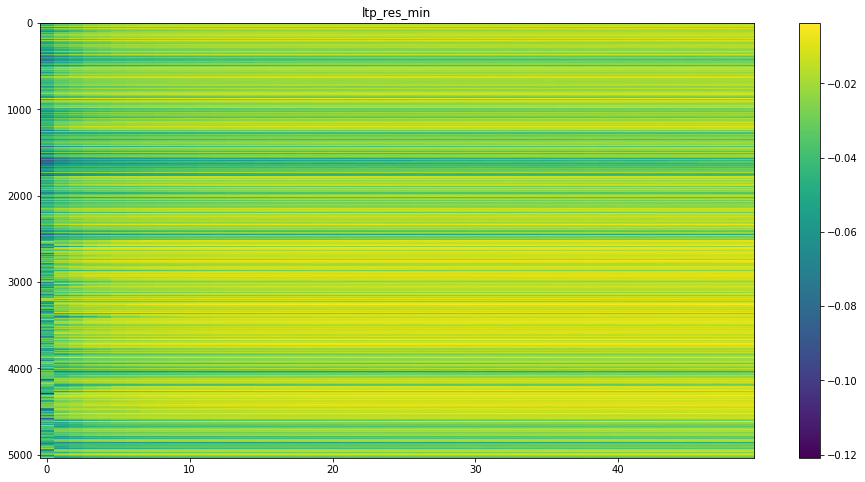

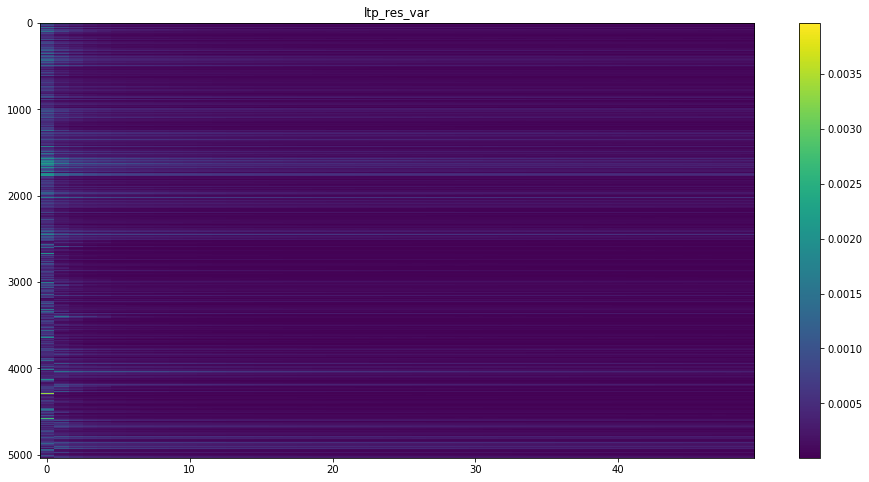

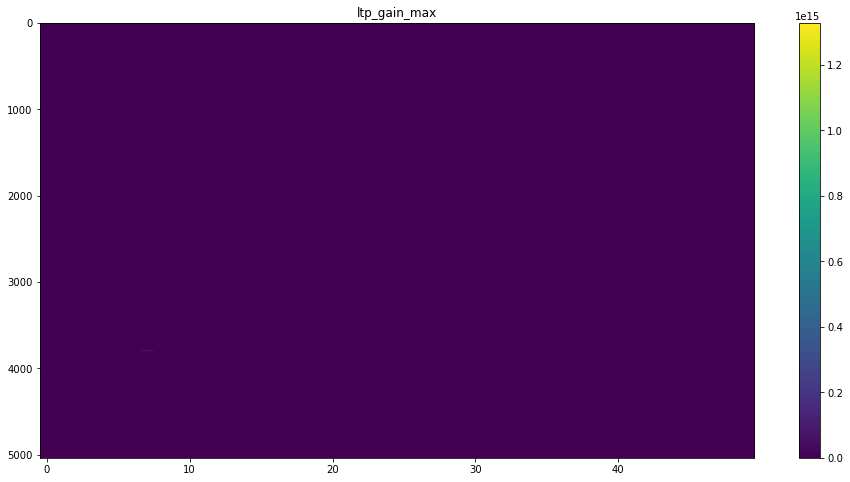

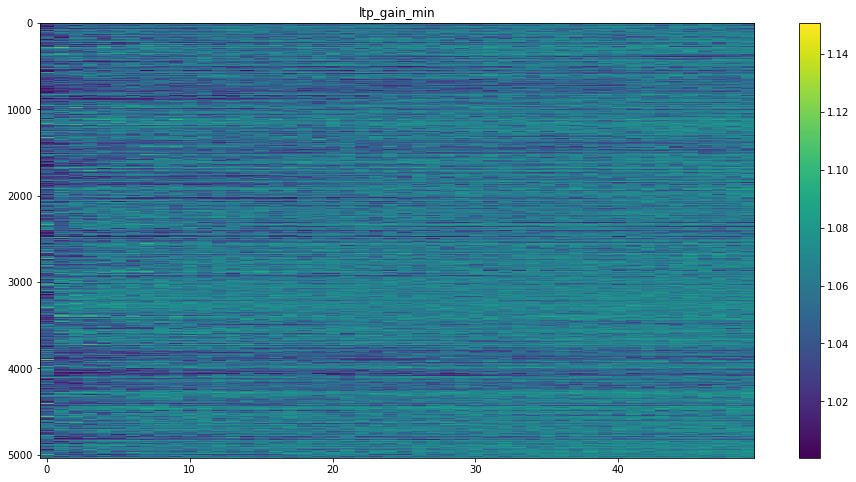

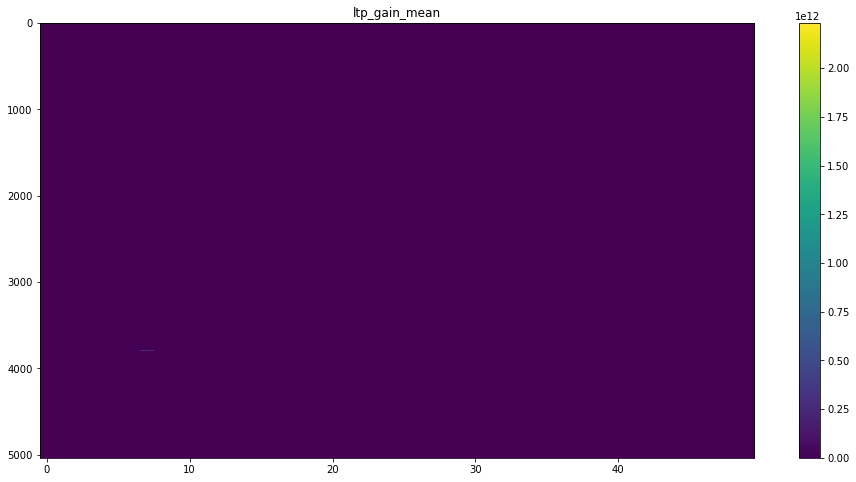

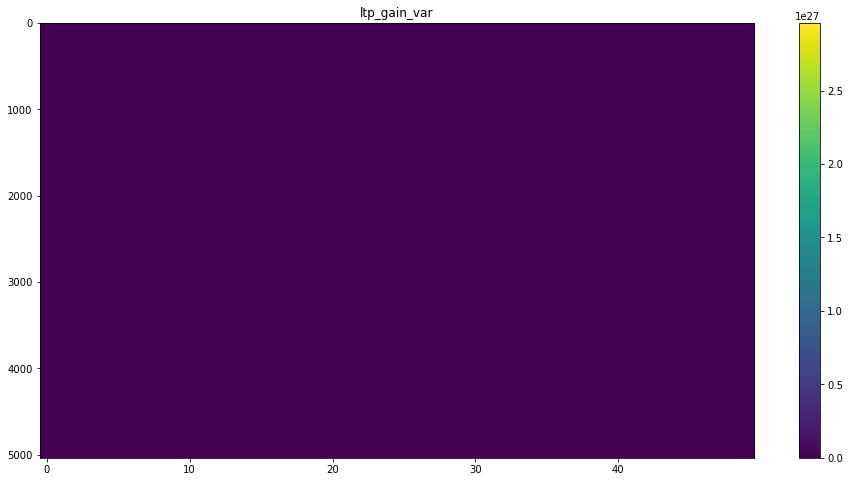

In [12]:
import sklearn.preprocessing

feature_list = ['lpc_res_mean', 'lpc_res_max', 'lpc_res_min', 
                'lpc_res_var', 'lpc_gain_max', 'lpc_gain_min', 'lpc_gain_mean', 'lpc_gain_var',
                'ltp_res_mean', 'ltp_res_max', 'ltp_res_min', 
                'ltp_res_var', 'ltp_gain_max', 'ltp_gain_min', 'ltp_gain_mean', 'ltp_gain_var']

n_features = 16
lpc_lenght = 50
norm_X_train = np.zeros(reshaped_X_train.shape)
feature_index = 1

for feature_index in np.arange(n_features):
    plt.figure(figsize=(16, 8))
    norm_X_train[:, feature_index, :] = sklearn.preprocessing.normalize(reshaped_X_train[:, feature_index, :])
    plt.title(feature_list[feature_index])
    plt.imshow(reshaped_X_train[:, feature_index, :], aspect='auto')
    plt.colorbar()

In [13]:
norm_X_dev = np.zeros(reshaped_X_dev.shape)

for feature_index in np.arange(n_features):
    norm_X_dev[:, feature_index, :] = sklearn.preprocessing.normalize(reshaped_X_dev[:, feature_index, :])


In [14]:
norm_X_eval = np.zeros(reshaped_X_eval.shape)

for feature_index in np.arange(n_features):
    norm_X_eval[:, feature_index, :] = sklearn.preprocessing.normalize(reshaped_X_eval[:, feature_index, :])


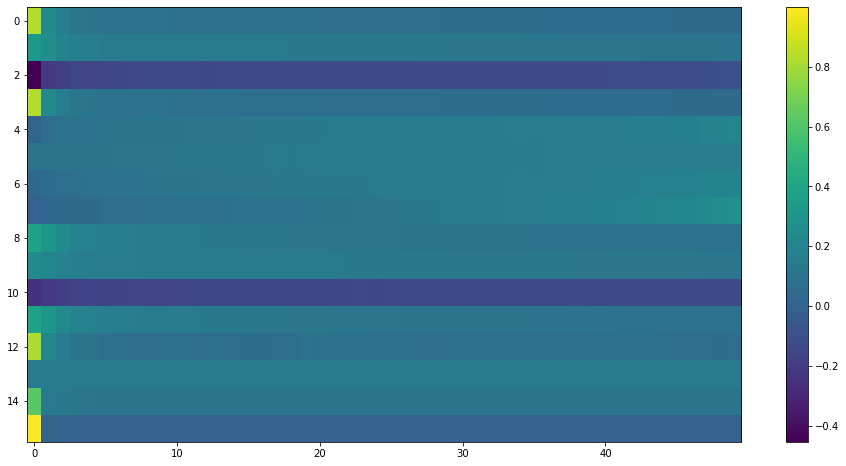

In [15]:
plt.figure(figsize=(16, 8))
plt.imshow(norm_X_train[-1, :, :], aspect='auto')
plt.colorbar()

## Train tutorial CNN

In [16]:
logdir = "logs/scalars/model1_" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=logdir)

In [17]:
batch_size = 128
num_classes = 2
epochs = 12


# convert class vectors to binary class matrices
y_train_cat = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_dev_cat = tensorflow.keras.utils.to_categorical(y_dev, num_classes)



In [18]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=[16, 50, 1]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 46, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 23, 64)         0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 23, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8832)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1130624   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [19]:
model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics=['accuracy'])

reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.001)

training_history = model.fit(np.expand_dims(norm_X_train, axis=3), y_train_cat,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
         callbacks=[reduce_lr, tensorboard_callback])

print("Average test loss: ", np.average(training_history.history['loss']))


Train on 5036 samples
Epoch 1/12
5036/5036 [==============================] - 9s 2ms/sample - loss: 0.6209 - accuracy: 0.6495
Epoch 2/12
5036/5036 [==============================] - 9s 2ms/sample - loss: 0.4885 - accuracy: 0.7714
Epoch 3/12
5036/5036 [==============================] - 9s 2ms/sample - loss: 0.3782 - accuracy: 0.8392
Epoch 4/12
5036/5036 [==============================] - 9s 2ms/sample - loss: 0.3132 - accuracy: 0.8751
Epoch 5/12
5036/5036 [==============================] - 9s 2ms/sample - loss: 0.2581 - accuracy: 0.8975
Epoch 6/12
5036/5036 [==============================] - 9s 2ms/sample - loss: 0.2382 - accuracy: 0.9053
Epoch 7/12
5036/5036 [==============================] - 9s 2ms/sample - loss: 0.2286 - accuracy: 0.9100
Epoch 8/12
5036/5036 [==============================] - 9s 2ms/sample - loss: 0.2156 - accuracy: 0.9184
Epoch 9/12
5036/5036 [==============================] - 9s 2ms/sample - loss: 0.2088 - accuracy: 0.9120
Epoch 10/12
5036/5036 [===================

In [20]:
score = model.evaluate(np.expand_dims(norm_X_dev, axis=3), y_dev_cat, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.17872082240521958
Test accuracy: 0.9251138


## Train on train and dev

In [21]:
logdir = "logs/scalars/model2_" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=logdir)

In [22]:
X_bonafide = np.concatenate((X_train_bonafide, X_dev_bonafide), axis=0)
X_spoof = np.concatenate((X_train_spoof, X_dev_spoof), axis=0)
                
X = np.concatenate((X_bonafide, X_spoof), axis=0)

In [23]:
y_bonafide = np.zeros([X_bonafide.shape[0],])
y_spoof = np.ones([X_spoof.shape[0],])

y = np.concatenate((y_bonafide, y_spoof), axis=0)

In [24]:
n_features = 16
lpc_lenght = 50
reshaped_X = np.zeros([X.shape[0], n_features, lpc_lenght ])
for n in np.arange(X.shape[0]):
    for i in np.arange(n_features):
        reshaped_X[n, i, :] = X[n, i::n_features]

print(reshaped_X.shape)

(9870, 16, 50)


In [25]:
norm_X = np.zeros(reshaped_X.shape)

for feature_index in np.arange(n_features):
    norm_X[:, feature_index, :] = sklearn.preprocessing.normalize(reshaped_X[:, feature_index, :])


In [26]:
y_cat = tensorflow.keras.utils.to_categorical(y, num_classes)
y_eval_cat = tensorflow.keras.utils.to_categorical(y_eval, num_classes)

In [27]:
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=[16, 50, 1]))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(num_classes, activation='softmax'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 48, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 23, 64)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 23, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8832)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1130624   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

In [28]:

model2.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics=['accuracy'])

reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.001)
model2.fit(np.expand_dims(norm_X, axis=3), y_cat,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)

Train on 9870 samples
Epoch 1/12
9870/9870 [==============================] - 18s 2ms/sample - loss: 0.5543 - accuracy: 0.7046
Epoch 2/12
9870/9870 [==============================] - 18s 2ms/sample - loss: 0.3541 - accuracy: 0.8523
Epoch 3/12
9870/9870 [==============================] - 18s 2ms/sample - loss: 0.2757 - accuracy: 0.8942
Epoch 4/12
9870/9870 [==============================] - 17s 2ms/sample - loss: 0.2382 - accuracy: 0.9096
Epoch 5/12
9870/9870 [==============================] - 18s 2ms/sample - loss: 0.2197 - accuracy: 0.9135
Epoch 6/12
9870/9870 [==============================] - 17s 2ms/sample - loss: 0.2030 - accuracy: 0.9217
Epoch 7/12
9870/9870 [==============================] - 18s 2ms/sample - loss: 0.1920 - accuracy: 0.9257
Epoch 8/12
9870/9870 [==============================] - 18s 2ms/sample - loss: 0.1869 - accuracy: 0.9266
Epoch 9/12
9870/9870 [==============================] - 18s 2ms/sample - loss: 0.1788 - accuracy: 0.9315
Epoch 10/12
9870/9870 [==========

In [29]:
score = model2.evaluate(np.expand_dims(norm_X_eval, axis=3), y_eval_cat, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.29862630880353125
Test accuracy: 0.88359374


## ASV metrics

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score


In [31]:
def obtain_asv_error_rates(tar_asv, non_asv, spoof_asv, asv_threshold):

    # False alarm and miss rates for ASV
    Pfa_asv = sum(non_asv >= asv_threshold) / non_asv.size
    Pmiss_asv = sum(tar_asv < asv_threshold) / tar_asv.size

    # Rate of rejecting spoofs in ASV
    if spoof_asv.size == 0:
        Pmiss_spoof_asv = None
    else:
        Pmiss_spoof_asv = np.sum(spoof_asv < asv_threshold) / spoof_asv.size

    return Pfa_asv, Pmiss_asv, Pmiss_spoof_asv


def compute_det_curve(target_scores, nontarget_scores):

    n_scores = target_scores.size + nontarget_scores.size
    all_scores = np.concatenate((target_scores, nontarget_scores))
    labels = np.concatenate((np.ones(target_scores.size), np.zeros(nontarget_scores.size)))

    # Sort labels based on scores
    indices = np.argsort(all_scores, kind='mergesort')
    labels = labels[indices]

    # Compute false rejection and false acceptance rates
    tar_trial_sums = np.cumsum(labels)
    nontarget_trial_sums = nontarget_scores.size - (np.arange(1, n_scores + 1) - tar_trial_sums)

    frr = np.concatenate((np.atleast_1d(0), tar_trial_sums / target_scores.size))  # false rejection rates
    far = np.concatenate((np.atleast_1d(1), nontarget_trial_sums / nontarget_scores.size))#false acceptance rates
    thresholds = np.concatenate((
        np.atleast_1d(all_scores[indices[0]] - 0.001), all_scores[indices]))  # Thresholds are the sorted scores

    return frr, far, thresholds

def compute_eer(target_scores, nontarget_scores):
    """ Returns equal error rate (EER) and the corresponding threshold. """
    frr, far, thresholds = compute_det_curve(target_scores, nontarget_scores)
    abs_diffs = np.abs(frr - far)
    min_index = np.argmin(abs_diffs)
    eer = np.mean((frr[min_index], far[min_index]))
    return eer, thresholds[min_index]

## ASV scores on model2

[0.43489957]
0.8858664772727273


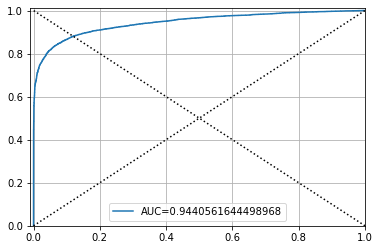

In [55]:
y_eval_hat = model2.predict(np.expand_dims(norm_X_eval, axis=3))[:,1]


[fpr, tpr, th] = roc_curve(y_eval, y_eval_hat, pos_label=1)
roc_auc = roc_auc_score(y_eval, y_eval_hat)

acc = (tpr + (1-fpr)) / 2
best_th = th[np.where(acc == np.max(acc))]
print(best_th)
print(acc.max())

plt.plot(fpr, tpr, label='AUC={}'.format(roc_auc))
plt.plot([0, 1], [0, 1], ':k')
plt.plot([1, 0], [0, 1], ':k')
plt.axis([-0.01, 1, 0, 1.01])
plt.grid(True)
plt.legend()
plt.show()

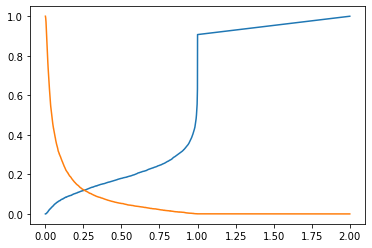

(0.11974431818181819, 0.25535592436790466)

In [54]:
target_score = y_eval_hat[np.where(y_eval==1)]
nontarget_score = y_eval_hat[np.where(y_eval==0)]

fnr = 1-tpr

plt.figure()
plt.plot(th, fnr)
plt.plot(th, fpr)
#plt.plot(th, np.abs(fnr-fpr))
plt.show()

compute_eer(target_score, nontarget_score)

## Eval model 2 bot by bot

In [43]:
bot_reshaped_X_eval_bonafide = np.zeros([X_eval_bonafide.shape[0], n_features, lpc_lenght ])
for n in np.arange(X_eval_bonafide.shape[0]):
    for i in np.arange(n_features):
        bot_reshaped_X_eval_bonafide[n, i, :] = X_eval_bonafide[n, i::n_features]

bot_norm_X_eval_bonafide = np.zeros(bot_reshaped_X_eval_bonafide.shape)

for feature_index in np.arange(n_features):
    bot_norm_X_eval_bonafide[:, feature_index, :] = sklearn.preprocessing.normalize(bot_reshaped_X_eval_bonafide
                                                                       [:, feature_index, :])

bot_y_eval_bonafide = np.zeros(bot_norm_X_eval_bonafide.shape[0])

In [44]:
bot_X_eval_spoof_list = []

eval_bot_systems = ['A11', 'A14', 'A16', 'A09', 'A13', 'A12', 'A18', 'A15', 'A08',
       'A17', 'A10', 'A07', 'A19']


lpc_lengths = np.arange(1, 51)

eval_bot_features = []

for b in eval_bot_systems:
    bot_X_eval_spoof_list = []
    selected_files = []
    for l in lpc_lengths:
        bot_eval_features = pd.read_pickle('/nas/home/cborrelli/bot_speech/features/bot/eval_LPC_' + 
                                       str(l) +'_bot_'+ str(b) +'.pkl')
        #eval_features.drop('coeff', axis=1, inplace=True)
        bot_eval_features.dropna(inplace=True)
        
        
        bot_X_eval_spoof_list.append(np.array(bot_eval_features['lpc_res_mean']).reshape((-1, 1)))
        bot_X_eval_spoof_list.append(np.array(bot_eval_features['lpc_res_max']).reshape((-1, 1)))
        bot_X_eval_spoof_list.append(np.array(bot_eval_features['lpc_res_min']).reshape((-1, 1)))
        bot_X_eval_spoof_list.append(np.array(bot_eval_features['lpc_res_var']).reshape((-1, 1)))
        bot_X_eval_spoof_list.append(np.array(bot_eval_features['lpc_gain_max']).reshape((-1, 1)))
        bot_X_eval_spoof_list.append(np.array(bot_eval_features['lpc_gain_min']).reshape((-1, 1)))
        bot_X_eval_spoof_list.append(np.array(bot_eval_features['lpc_gain_mean']).reshape((-1, 1)))
        bot_X_eval_spoof_list.append(np.array(bot_eval_features['lpc_gain_var']).reshape((-1, 1)))
        bot_X_eval_spoof_list.append(np.array(bot_eval_features['ltp_res_mean']).reshape((-1, 1)))
        bot_X_eval_spoof_list.append(np.array(bot_eval_features['ltp_res_max']).reshape((-1, 1)))
        bot_X_eval_spoof_list.append(np.array(bot_eval_features['ltp_res_min']).reshape((-1, 1)))
        bot_X_eval_spoof_list.append(np.array(bot_eval_features['ltp_res_var']).reshape((-1, 1)))
        bot_X_eval_spoof_list.append(np.array(bot_eval_features['ltp_gain_max']).reshape((-1, 1)))
        bot_X_eval_spoof_list.append(np.array(bot_eval_features['ltp_gain_min']).reshape((-1, 1)))
        bot_X_eval_spoof_list.append(np.array(bot_eval_features['ltp_gain_mean']).reshape((-1, 1)))
        bot_X_eval_spoof_list.append(np.array(bot_eval_features['ltp_gain_var']).reshape((-1, 1)))

    bot_X_eval_spoof = np.concatenate(bot_X_eval_spoof_list, axis=1)
    
    n_features = 16
    lpc_lenght = 50
    
    bot_reshaped_X_eval_spoof = np.zeros([bot_X_eval_spoof.shape[0], n_features, lpc_lenght ])
    for n in np.arange(bot_X_eval_spoof.shape[0]):
        for i in np.arange(n_features):
            bot_reshaped_X_eval_spoof[n, i, :] = bot_X_eval_spoof[n, i::n_features]
    
    bot_norm_X_eval_spoof = np.zeros(bot_reshaped_X_eval_spoof.shape)

    for feature_index in np.arange(n_features):
        bot_norm_X_eval_spoof[:, feature_index, :] = sklearn.preprocessing.normalize(bot_reshaped_X_eval_spoof
                                                                           [:, feature_index, :])

    bot_y_eval_spoof = np.ones((bot_X_eval_spoof.shape[0],))
    

    eval_bot_features.append({'bot': b, 'X_eval_spoof': bot_norm_X_eval_spoof, 'y_eval_spoof': bot_y_eval_spoof})

(7040,)

[0.10398114]
0.7863142103748686


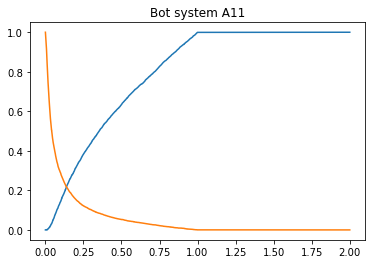

(0.21737466139786865, 0.13874413073062897)
[0.30659243]
0.9154987895052924


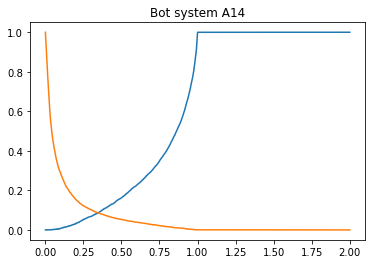

(0.08583744651302455, 0.34684446454048157)
[0.08482874]
0.7213336038080874


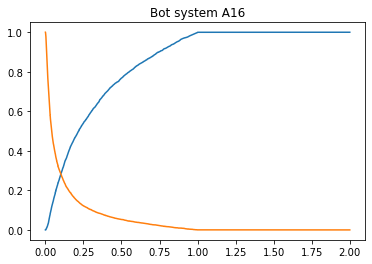

(0.2836671293694919, 0.10209294408559799)
[0.499573]
0.9593635471519781


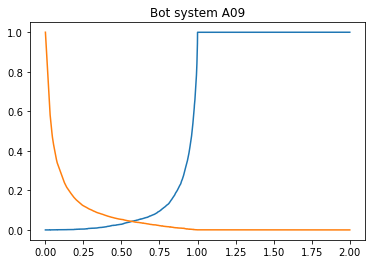

(0.04287895062978608, 0.5658972859382629)
[0.24541356]
0.8849490025624138


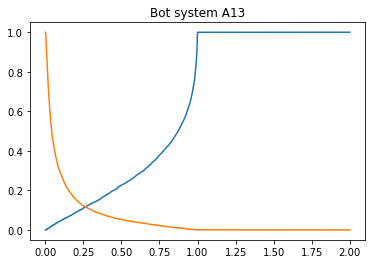

(0.11660714607302365, 0.26271674036979675)
[0.0055551]
0.5016244550167914


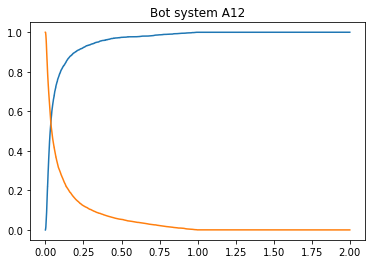

(0.540923329209136, 0.0358683206140995)
[0.15786797]
0.8134202615917828


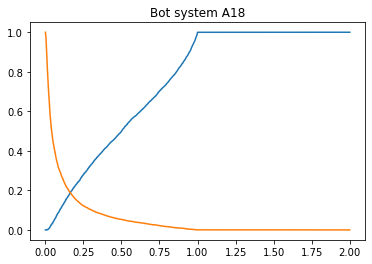

(0.18904214278086287, 0.1638835370540619)
[0.01816211]
0.5613123184270596


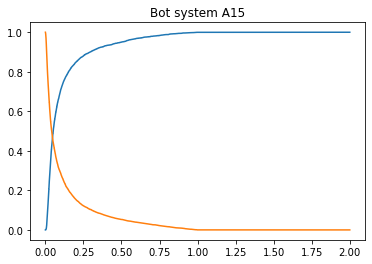

(0.46623624643928385, 0.04712266847491264)
[0.33645368]
0.9309490756815206


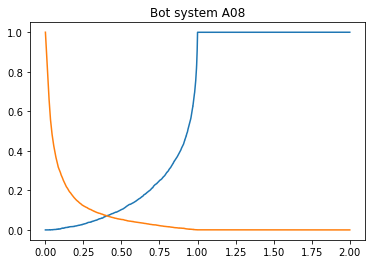

(0.07115637152295544, 0.40444159507751465)
[0.19754489]
0.6060828063031843


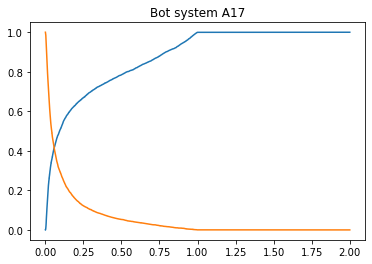

(0.41549243025875016, 0.05795425921678543)
[0.01208672]
0.5162697377660962


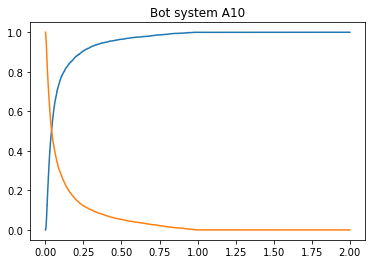

(0.5038487546648341, 0.04113877937197685)
[0.10446717]
0.7750943033362125


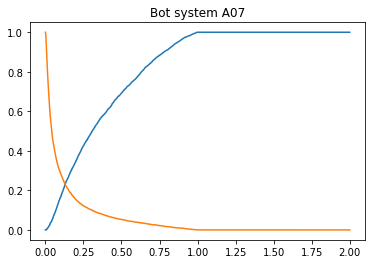

(0.23125877240336862, 0.13050806522369385)
[0.12457565]
0.748544692817722


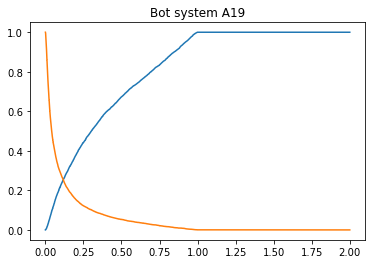

(0.2529670253334355, 0.11773838102817535)


In [58]:
for b in eval_bot_systems:
    bot_X_eval_spoof = [d['X_eval_spoof'] for d in eval_bot_features if d['bot'] == b][0]
    bot_y_eval_spoof = [d['y_eval_spoof'] for d in eval_bot_features if d['bot'] == b][0]
    
    bot_X_eval = np.concatenate((bot_norm_X_eval_bonafide, bot_X_eval_spoof), axis=0)
    bot_y_eval = np.concatenate((bot_y_eval_bonafide, bot_y_eval_spoof), axis=0)
    
    
    bot_y_eval_hat = model2.predict(np.expand_dims(bot_X_eval, axis=3))[:,1]

    
    [fpr, tpr, th] = roc_curve(bot_y_eval, bot_y_eval_hat, pos_label=1)
    fnr = 1-tpr
    
    acc = (tpr + (1-fpr)) / 2
    best_th = th[np.where(acc == np.max(acc))]
    print(best_th)
    print(acc.max())
    
    plt.figure()
    plt.title('Bot system %s' %b)
    plt.plot(th, fnr)
    plt.plot(th, fpr)
    #plt.plot(th, np.abs(fnr-fpr))
    plt.show()
    
    bot_target_score = bot_y_eval_hat[np.where(bot_y_eval==1)]
    bot_nontarget_score = bot_y_eval_hat[np.where(bot_y_eval==0)]

    print(compute_eer(bot_target_score, bot_nontarget_score))


In [47]:
bot_y_eval_hat.shape

(11621,)

In [48]:
bot_y_eval.shape

(11621,)

In [49]:
bot_target_score = bot_y_eval_hat[np.where(y_eval==1)]

IndexError: index 11621 is out of bounds for axis 0 with size 11621